In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install python-dotenv
!pip install pydub
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.1 MB/s eta 0:00:00


In [3]:
!pip install fuzzywuzzy[speedup]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.7 MB/s eta 0:00:00


In [4]:
pip show openai


Name: openai
Version: 1.54.4
Summary: The official Python library for the openai API
Home-page: https://github.com/openai/openai-python
Author: 
Author-email: OpenAI <support@openai.com>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: anyio, distro, httpx, jiter, pydantic, sniffio, tqdm, typing-extensions
Required-by: 


## 시간별 점수

In [5]:
import os
from openai import OpenAI
from pydub import AudioSegment
import librosa
from sklearn.metrics.pairwise import cosine_similarity
from tempfile import NamedTemporaryFile
from dotenv import load_dotenv
import soundfile as sf
from fuzzywuzzy import fuzz
import re
from dotenv import load_dotenv
from tempfile import NamedTemporaryFile
import math
from jiwer import wer

# 작업 디렉토리 설정
os.chdir('/content/drive/MyDrive/kakaotech-14-ai')
load_dotenv()

client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key="XXXXXXXXX"
)

In [6]:
def convert_to_mp3(file_path):
    """
    주어진 오디오 파일을 MP3 형식으로 변환합니다.

    Args:
        file_path (str): 입력 오디오 파일 경로.

    Returns:
        str: 변환된 MP3 파일 경로.
        None: 변환 실패 시.
    """
    file_extension = file_path.split('.')[-1].lower()  # 파일 확장자 확인
    supported_formats = ['flac', 'm4a', 'mp3', 'mp4', 'mpeg', 'mpga', 'oga', 'ogg', 'wav', 'webm']

    if file_extension == 'mp3':  # 이미 MP3이면 변환하지 않음
        return file_path
    elif file_extension not in supported_formats:  # 지원하지 않는 형식 처리
        print(f"지원되지 않는 파일 형식입니다: {file_extension}")
        return None
    try:
        # 오디오 파일을 읽어서 MP3로 변환
        audio = AudioSegment.from_file(file_path, format=file_extension)
        mp3_file_path = file_path.rsplit(".", 1)[0] + ".mp3"
        audio.export(mp3_file_path, format="mp3")
        return mp3_file_path
    except Exception as e:
        print(f"오류 발생: {e}")
        return None

In [7]:
def STT(file_path):
    """
    주어진 오디오 파일을 텍스트로 변환(STT).

    Args:
        file_path (str): 입력 오디오 파일 경로.

    Returns:
        str: 변환된 텍스트.
        None: 변환 실패 시.
    """
    try:
        # 원본 오디오 파일을 그대로 사용하여 STT 수행
        with open(convert_to_mp3(file_path), "rb") as audio_file:
            response = client.audio.transcriptions.create(
                model="whisper-1",
                file=audio_file,
                language='ko'
            )
        # 실제 텍스트를 추출
        transcript = response.text  # 또는 transcript = response.text

        return transcript
    except Exception as e:
        print(f"STT 변환 오류: {e}")
        return None


In [8]:
def TTS(script, output_path="TTS.mp3", speed=1.0):
    """
    텍스트를 음성으로 변환(TTS)합니다. 스크립트가 4000자 이상일 경우, 분할하여 여러 개의 음성 파일을 생성한 후 결합합니다.

    Args:
        script (str): 입력 텍스트.
        output_path (str): 생성될 음성 파일 경로.
        speed (float): 음성 속도 조절 (0.5 ~ 4.0).

    Returns:
        str: 생성된 음성 파일 경로.
        None: 변환 실패 시.
    """
    try:
        num = math.ceil(len(script) / 4000)
        if num == 1:
            response = client.audio.speech.create(
                model="tts-1",
                voice="alloy",
                input=script,
                speed=speed
            )
            with open(output_path, 'wb') as f:
                f.write(response.content)  # 수정된 부분
        else:
            tts_files = []
            for i in range(num):
                segment = script[4000 * i : 4000 * (i + 1)]
                tts_segment_path = f"TTS{i}.mp3"
                response = client.audio.speech.create(
                    model="tts-1",
                    voice="alloy",
                    input=segment,
                    speed=speed
                )
                with open(tts_segment_path, 'wb') as f:
                    f.write(response.content)  # 수정된 부분
                tts_files.append(tts_segment_path)

            # 여러 개의 TTS 파일을 결합
            combined_audio = AudioSegment.empty()
            for tts_file in tts_files:
                audio_segment = AudioSegment.from_mp3(tts_file)
                combined_audio += audio_segment
                os.remove(tts_file)  # 임시 파일 삭제

            combined_audio.export(output_path, format="mp3")

        print(f"TTS 생성 완료: {output_path}")
        return output_path
    except Exception as e:
        print(f"TTS 변환 오류: {e}")
        return None

In [9]:
def compare_audio_similarity(file1, file2):
    """
    두 오디오 파일 간 유사도를 계산합니다.

    Args:
        file1 (str): 첫 번째 오디오 파일 경로.
        file2 (str): 두 번째 오디오 파일 경로.

    Returns:
        float: 유사도 점수 (0~1).
        None: 계산 실패 시.
    """
    try:
        # 오디오 로드
        y1, sr1 = librosa.load(file1, sr=None)
        y2, sr2 = librosa.load(file2, sr=None)

        # 두 파일 길이 맞추기
        min_len = min(len(y1), len(y2))
        y1, y2 = y1[:min_len], y2[:min_len]

        # MFCC 특징 추출 및 코사인 유사도 계산
        mfcc1 = librosa.feature.mfcc(y=y1, sr=sr1)
        mfcc2 = librosa.feature.mfcc(y=y2, sr=sr2)
        similarity = cosine_similarity(mfcc1.T, mfcc2.T).mean()
        return similarity
    except Exception as e:
        print(f"오디오 유사도 비교 오류: {e}")
        return None

In [10]:
def calculate_audio_duration(audio_path):
    """
    오디오 길이를 계산합니다 (무음 제거 안 함).
    """
    audio = AudioSegment.from_file(audio_path)
    duration_seconds = len(audio) / 1000.0  # 밀리초 단위에서 초 단위로 변환
    return duration_seconds

In [11]:
def count_words(text):
    """
    텍스트의 단어 수를 계산합니다.
    """
    try:
        words = text.split()
        return len(words)
    except Exception as e:
        print(f"단어 수 계산 오류: {e}")
        return 0

In [12]:
def calculate_speed(audio_file_path, text):
    """
    오디오 파일의 말하기 속도를 계산합니다 (단어/분 기준).

    Args:
        audio_file_path (str): 입력 오디오 파일 경로.
        text (str): 음성 텍스트.

    Returns:
        float: 말하기 속도 (WPM).
        None: 계산 실패 시.
    """
    try:
        # Step 1: 오디오 길이 계산 (무음 제거 안 함)
        duration_seconds = calculate_audio_duration(audio_file_path)

        # Step 2: 단어 수 계산
        word_count = count_words(text)

        # Step 3: WPM 계산
        duration_minutes = duration_seconds / 60.0
        if duration_minutes > 0:
            wpm = word_count / duration_minutes
        else:
            wpm = 0
        return wpm

    except Exception as e:
        print(f"속도 계산 오류: {e}")
        return None


In [13]:
def adjust_audio_length(audio_path, target_duration):
    """
    TTS 음성 길이를 사용자 음성과 동기화합니다.

    Args:
        audio_path (str): TTS 음성 파일 경로.
        target_duration (float): 목표 길이 (초).

    Returns:
        str: 수정된 오디오 파일 경로.
    """
    audio = AudioSegment.from_file(audio_path)
    current_duration = len(audio) / 1000  # 밀리초 단위에서 초 단위로 변환

    if current_duration < target_duration:
        # 길이가 짧으면 침묵 추가
        silence = AudioSegment.silent(duration=(target_duration - current_duration) * 1000)
        adjusted_audio = audio + silence
    else:
        # 길이가 길면 자름
        adjusted_audio = audio[:int(target_duration * 1000)]

    adjusted_audio.export(audio_path, format="mp3")
    return audio_path


In [14]:
def preprocess_text(text):
    """
    텍스트 전처리 함수: 소문자 변환 및 일부 특수 문자 제거

    Args:
        text (str): 입력 텍스트.

    Returns:
        str: 전처리된 텍스트.
    """
    try:
        text = text.lower()
        # 한국어의 조사나 어미를 유지하기 위해 특수 문자를 일부만 제거
        text = re.sub(r'[^\w\s가-힣]', '', text)
        return text
    except Exception as e:
        print(f"텍스트 전처리 오류: {e}")
        return text

In [15]:
def analyze_pronunciation_accuracy(stt_text, reference_text):
    """
    사용자가 실제로 말한 텍스트(STT 변환 결과)와 기준 텍스트(대본) 간의 일치도를 계산합니다.

    Args:
        stt_text (str): STT로 변환된 사용자의 발화 텍스트.
        reference_text (str): 기준이 되는 대본 텍스트.

    Returns:
        float: 두 텍스트 간의 유사도(0~1)로 표현된 일치도 점수.
        None: 계산 중 오류 발생 시.
    """
    try:
        # 텍스트 전처리: 공백, 구두점 제거 등 비교를 위한 정규화
        stt_text_processed = preprocess_text(stt_text)
        reference_text_processed = preprocess_text(reference_text)

        # 유사도 계산: 텍스트 간 단어 집합 비교를 통한 유사도 산출
        accuracy = fuzz.token_set_ratio(stt_text_processed, reference_text_processed) / 100.0
        return accuracy
    except Exception as e:
        print(f"일치도 계산 오류: {e}")
        return None


In [16]:
def correct_text_with_llm(text):
    """
    텍스트를 LLM을 사용하여 보정합니다.

    Args:
        text (str): 보정할 텍스트.

    Returns:
        str: 보정된 텍스트.
        원본 텍스트: 보정 실패 시.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system",
                    "content": "너는 한국어 문법을 정확하게 교정하지만, 어떤 내용도 삭제하거나 요약하지 않는 어시스턴트야. 텍스트에 부족한 내용을 보충한다는 느낌으로 원본 텍스트보다는 늘려도 되지만 절대 줄이지 말고 자연스럽게 교정해줘."
                },
                {
                    "role": "user",
                    "content": f"다음 텍스트의 문법을 자연스럽게 교정하세요. 단, **어떤 단어도 삭제하거나 요약하지 말고, 부자연스러운 표현은 고쳐줘, 텍스트의 길이는 원본 텍스트보다 길어도 돼, 그리고 텍스트는 절대 문단을 나누지 말고 무조건 하나의 텍스트로 만들어줘**.:\n\n{text}"
                }
            ],
            max_tokens=4000,
        )
        corrected_text = response.choices[0].message.content.strip()
        return corrected_text
    except Exception as e:
        print(f"LLM 보정 오류: {e}")
        return text

In [17]:
def analyze_low_accuracy(audio_file_path, script_text, chunk_size=60):
    """
    60초 단위로 오디오를 분할하여 발음 정확도를 분석하고 평균을 계산합니다.

    Args:
        audio_file_path (str): 입력 오디오 파일 경로.
        script_text (str): 기준 텍스트.
        chunk_size (int, optional): 구간 길이 (초). 기본값은 60초.

    Returns:
        tuple: 각 구간의 (시간, 정확도) 리스트와 평균 정확도.
    """
    accuracies = []  # 정확도 정보를 저장할 리스트
    wpms = []  # (시간, WPM) 정보를 저장할 리스트

    try:
        y, sr = librosa.load(audio_file_path, sr=None)  # 오디오 파일 로드
        duration = librosa.get_duration(y=y, sr=sr)  # 오디오 파일 길이 계산

        for i in range(0, int(duration), chunk_size):
            # chunk_size 초 단위로 오디오 분할
            segment = y[i * sr:(i + chunk_size) * sr]

            # 임시 파일로 저장 후 STT 처리
            with NamedTemporaryFile(delete=True, suffix=".wav") as temp_audio:
                sf.write(temp_audio.name, segment, sr)
                segment_text = STT(temp_audio.name)
                if not segment_text:
                    print(f"Segment {i} STT 변환에 실패했습니다.")
                    continue

            # 구간별 정확도 계산
            accuracy = analyze_pronunciation_accuracy(segment_text, script_text)

            # 구간별 WPM 계산
            word_count = count_words(segment_text)  # 해당 구간의 단어 수 계산
            wpm = word_count / (chunk_size / 60)  # 분당 단어 수 계산

            # 시간 표시
            start_min = i // 60
            start_sec = i % 60
            end_min = (i + chunk_size) // 60
            end_sec = (i + chunk_size) % 60
            time_str = f"{start_min}분 {start_sec}초 - {end_min}분 {end_sec}초"

            # 결과 저장
            accuracies.append((time_str, accuracy))
            wpms.append((time_str, wpm))

        # 평균 발음 정확도 계산
        if accuracies:
            average_accuracy = sum(accuracy for _, accuracy in accuracies) / len(accuracies)
        else:
            average_accuracy = 0.0

        return accuracies, wpms, average_accuracy

    except Exception as e:
        print(f"정확도 및 WPM 분석 오류: {e}")
        return [], [], 0.0

In [18]:
def calculate_presentation_score(audio_file_path, script_text=None):
    """
    프레젠테이션 음성을 분석하여 점수를 계산합니다.

    Args:
        audio_file_path (str): 입력 오디오 파일 경로.
        script_text (str, optional): 기준 텍스트 (사용자가 제공한 스크립트). 제공되지 않으면 STT 결과를 사용.

    Returns:
        dict: 분석 결과를 포함한 점수 데이터. (오디오 유사도, 말하기 속도, 발음 정확도)
        None: 처리 실패 시.
    """

    # --- 음성 정보 ---
    # Step 1: STT(음성을 텍스트로 변환)
    stt_text = STT(audio_file_path)
    if not stt_text:
        print("STT 변환에 실패했습니다.")
        return None
    # print("STT 변환된 텍스트:\n", stt_text)  # 필요 시 주석 해제

    # Step 2: 기준 텍스트 확인
    if script_text:
        # 사용자가 제공한 스크립트를 기준으로 사용
        print("사용자가 제공한 스크립트를 사용합니다.")
    else:
        # 기준 스크립트가 없는 경우, LLM을 통해 STT 결과를 보정하여 사용
        print("스크립트가 제공되지 않았습니다. LLM으로 텍스트를 보정합니다.")
        script_text = correct_text_with_llm(stt_text)
        # print("LLM으로 보정된 텍스트:\n", script_text)

    print("— 음성 정보 —")

    # Step 3: WPM 계산 (decoded_text 기반)
    audio_duration = calculate_audio_duration(audio_file_path)
    word_count = count_words(stt_text)
    user_speed = calculate_speed(audio_file_path, stt_text)
    print(f"오디오 길이 (초): {audio_duration:.2f}")
    print(f"텍스트 단어 수: {word_count}")
    print(f"사용자 발표 WPM: {user_speed:.2f}")

    # Step 4: TTS 속도 설정
    average_wpm = 100  # 평균 말하기 속도
    tts_speed_ratio = user_speed / average_wpm  # TTS 속도 비율 계산
    tts_speed_ratio = max(0.5, min(tts_speed_ratio, 4.0))  # 속도 제한 적용
    print(f"TTS 속도 설정: {tts_speed_ratio:.2f}")

    # TTS 생성
    tts_file_path = TTS(script_text, speed=tts_speed_ratio)
    if not tts_file_path:
        print("TTS 변환에 실패했습니다.")
        return None

    # TTS 속도 (WPM) 계산
    tts_wpm = tts_speed_ratio * average_wpm
    print(f"TTS WPM: {tts_wpm:.2f} WPM")

    # Step 5: TTS와 사용자 음성 길이 동기화
    adjust_audio_length(tts_file_path, audio_duration)

    # --- 발음 정확도 계산 ---
    print("\n— 구간별 발음 정확도 계산 —")
    low_accuracies, wpms, average_accuracy = analyze_low_accuracy(audio_file_path, script_text, chunk_size=60)

    for time_str, accuracy in low_accuracies:
      print(f"{time_str} 구간의 발음 정확도: {accuracy:.2f}")

    print("\n- 구간별 WPM -")
    for time_str, wpm in wpms:
        print(f"{time_str}구간의 WPM: {wpm:.2f}")

    # Step 6: 오디오 유사도 계산
    audio_similarity = compare_audio_similarity(audio_file_path, tts_file_path)
    if audio_similarity is None:
        print("오디오 유사도 비교에 실패했습니다.")
        return None

    # Step 7: 발음 정확도 계산
    pronunciation_accuracy = analyze_pronunciation_accuracy(stt_text, script_text)
    if pronunciation_accuracy is None:
        print("발음 정확도 분석에 실패했습니다.")
        return None

    # 최종 결과 반환
    return {
        "audio_similarity": audio_similarity,
        "original_speed": user_speed,
        "tts_speed": tts_wpm,  # 실제 WPM으로 환산
        "average_accuracy": average_accuracy,
        "pronunciation_accuracy": pronunciation_accuracy
    }

In [21]:
# 예시 사용법
if __name__ == "__main__":
    # 예시 오디오 파일 경로
    audio_file = "002ece7f4ec7acb1.mp3"

    # 스크립트가 제공된 경우
    user_script = None  # 실제 스크립트로 교체하거나 None으로 설정

    # 스크립트가 없는 경우 (LLM으로 보정)
    # user_script = None

    # 음성 평가 처리
    results = calculate_presentation_score(audio_file, script_text=user_script)

    if results:
      print("\n- 평가 결과 -")
      print(f"오디오 유사도: {results['audio_similarity']:.2f}")
      print(f"평균 사용자 말하기 속도 (WPM): {results['original_speed']:.2f}")
      print(f"TTS 속도 (WPM): {results['tts_speed']:.2f}")
      print(f"평균 사용자 발음 정확도: {results['average_accuracy']:.2f}") # 평균 발음 정확도
      print(f"대본 텍스트와 일치도 (대본 미 제공 시 문법 일치도): {results['pronunciation_accuracy']:.2f}") # 대본 텍스트와 일치도

STT 변환된 텍스트:
 발표 시작하겠습니다. 안녕하세요. 저는 이번에 인공지능과 파이썬으로 금융 데이터 분석해보기 윗자연어처리로 발표하게 될 김대현이라고 합니다. 일단 제 소개를 간단하게 드리자면, 저는 지금 모듈 연구소라는 곳에서 비전 랭키지 쪽으로 모델 연구를 하고 있고요. 또한 카카오테크 부트캡에서 생선형 인공지능 과정을 소강하고 있습니다. 최근에 고파콘이라고 고언어 관련해서 열리는 큰 행사가 있는데 거기 준비위원회로 참가를 했고 이제 또 JRC라는 로봇 회사에서 로보틱스 엔지니어로 근무한 경력이 있습니다. 일단은 크게 4가지 주제를 다뤄볼 거에요. 이제 TF-IDF N-GRAM, COVERT, 다이노싱 메소드, 포지티브 인덱스 리얼리티, 즉 이제 신뢰지수에 대해서 한번 얘기를 해보려고 합니다. 일단은 이 프로젝트를 먼저 시작하게 된 계기가 바로 이거였어요. 일반적으로 우리가 주식을 할 때 처음에 화면을 보면 어떠한 걸 봐야 될지 모르겠는 거에요. 그래서 복잡한 리서치 화면 및 뉴스 커뮤니티에 통한 투자 결정에 어려움이 존재해서 이 프로젝트를 진행하게 되었고 또한 이제 일단은 한국 투자증권 기준으로 보면 카테고리가 일단은 종목이 2400개가 있어요. 이것을 10개의 섹터로만 구분해서 의사결정에 대해서 어려운 점이 있었습니다. 그래서 이 프로젝트를 진행하게 되었고 요약해드리자면 이제 우리가 이걸 왜 하게 되었는지 중요 정보에 쉽게 접근하고 이제 정확한 투자 동향을 파악하면서 이제 유망한 분야에 탐색하고 또한 이제 여론과 어느정도 상관관계 분석이 있는지 그거를 파악하면서 개발해 보려고 했습니다. 일단은 개발 설계 및 연구방법에 대해서 설명을 드리면 일단은 모델을 선정이랑 이제 어떻게 프로젝트를 진행하지 플레이닝을 했고요. 건담의 이제 데이터 수집 및 전처리, 부위 체계 세부나 키워드 감성 분석, 적용 데이터 분석, 데이터 시각화 이렇게 다섯가지로 구성을 했습니다. 일단 일반적으로 인공지능 관련한 프로젝트를 시작할 때 이제 데이터 수집을 해야 되잖아요. 그래

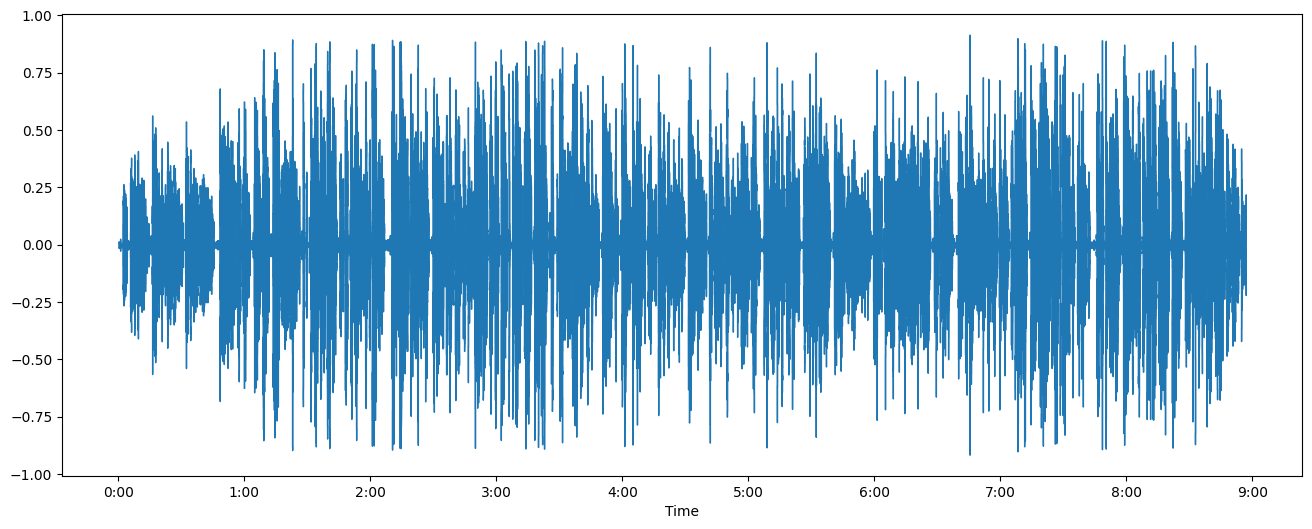

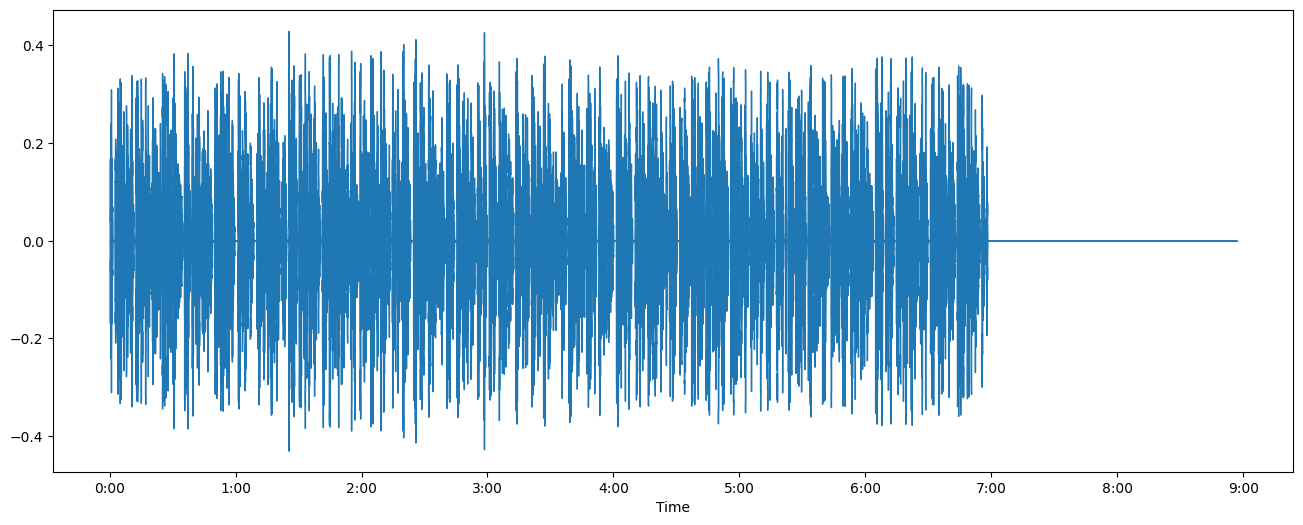

In [22]:
import matplotlib.pyplot as plt
import librosa.display

data, sample_rate = librosa.load('002ece7f4ec7acb1.mp3', sr = 16000)
plt.figure(figsize =(16,6))
librosa.display.waveshow(y=data,sr=sample_rate)
plt.show()

data, sample_rate = librosa.load('TTS.mp3', sr = 16000)
plt.figure(figsize =(16,6))
librosa.display.waveshow(y=data,sr=sample_rate)
plt.show()